In [12]:
# %% [markdown]
# # Homework 2 - Question 4: Vega Immunization Strategy
# 
# **Objective**: Implement and test the Vega immunization strategy to hedge a short 
# position in a call option using:
# 1. The underlying asset (SPX)
# 2. Money market account  
# 3. Another call option (for vega hedging)
#
# **Key Parameters**:
# - Hedged option: Call with expiry 6/18/2026, strike 5000
# - Hedging option: Call with expiry 3/31/2025, strike 5900
# - Hedging period: 8/7/2024 to end of Feb 2025

# %% [markdown]
# ## Block 1: Imports

# %%
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pandas_datareader as web
from scipy.stats import norm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# ## Block 2: Black-Scholes Pricing Functions

# %%
def blackPremium(discountFactor, forward, strike, timeToExpiration, isCall, sigma):
    """
    Calculate option premium using Black's formula.
    """
    if timeToExpiration <= 0:
        if isCall:
            return max(forward - strike, 0) * discountFactor
        else:
            return max(strike - forward, 0) * discountFactor
    
    with np.errstate(divide='ignore', invalid='ignore'):
        terminalVolatility = sigma * np.sqrt(timeToExpiration)
        if terminalVolatility == 0:
            if isCall:
                return discountFactor * max(forward - strike, 0)
            else:
                return discountFactor * max(strike - forward, 0)
        
        logMoneyness = np.log(forward / strike)
        d1 = logMoneyness / terminalVolatility + 0.5 * terminalVolatility
        d2 = logMoneyness / terminalVolatility - 0.5 * terminalVolatility
        
        forwardCallPremium = forward * norm.cdf(d1) - strike * norm.cdf(d2)
        
        if isCall:
            return discountFactor * forwardCallPremium
        else:
            return discountFactor * (forwardCallPremium - (forward - strike))

# %%
def blackVolatility(discountFactor, forward, strike, timeToExpiration, isCall, premium):
    """
    Calculate implied volatility using bisection method.
    """
    def getPremium(sigma):
        return blackPremium(discountFactor, forward, strike, timeToExpiration, isCall, sigma)
    
    if np.isnan(premium):
        return np.nan
    elif premium <= getPremium(0.0):
        return 0.0
    elif premium >= getPremium(np.inf):
        return np.inf
    
    low = 0.0
    high = 1.0
    while getPremium(high) < premium:
        high = 2.0 * high
    
    while high - low > 1.0e-8:
        mid = 0.5 * (low + high)
        if getPremium(mid) >= premium:
            high = mid
        else:
            low = mid
    
    return 0.5 * (low + high)

# %% [markdown]
# ## Block 3: Greek Calculations

# %%
def blackVega(discountFactor, forward, strike, timeToExpiration, sigma):
    """
    Calculate Black vega (sensitivity to implied volatility).
    Same for calls and puts.
    
    Vega = D * F * sqrt(T) * N'(d1)
    """
    if timeToExpiration <= 0:
        return 0.0
    
    with np.errstate(divide='ignore', invalid='ignore'):
        terminalVolatility = sigma * np.sqrt(timeToExpiration)
        if terminalVolatility == 0:
            return 0.0
        
        logMoneyness = np.log(forward / strike)
        d1 = logMoneyness / terminalVolatility + 0.5 * terminalVolatility
        
        return discountFactor * forward * np.sqrt(timeToExpiration) * norm.pdf(d1)

# %%
def spotDelta(discountFactor, forward, strike, timeToExpiration, isCall, sigma, spot, r, q):
    """
    Calculate delta with respect to spot price (not forward).
    
    Delta_spot = e^(-q*T) * N(d1) for call
    Delta_spot = -e^(-q*T) * N(-d1) for put
    """
    if timeToExpiration <= 0:
        if isCall:
            return 1.0 if spot > strike else 0.0
        else:
            return -1.0 if spot < strike else 0.0
    
    with np.errstate(divide='ignore', invalid='ignore'):
        terminalVolatility = sigma * np.sqrt(timeToExpiration)
        if terminalVolatility == 0:
            if isCall:
                return np.exp(-q * timeToExpiration) if forward > strike else 0.0
            else:
                return -np.exp(-q * timeToExpiration) if forward < strike else 0.0
        
        logMoneyness = np.log(forward / strike)
        d1 = logMoneyness / terminalVolatility + 0.5 * terminalVolatility
        
        if isCall:
            return np.exp(-q * timeToExpiration) * norm.cdf(d1)
        else:
            return -np.exp(-q * timeToExpiration) * norm.cdf(-d1)

# %% [markdown]
# ## Block 4: Load Options Data

# %%
# UPDATE THIS FILENAME if your data file has a different name
options_filename = 'Midprices.csv'

try:
    spxOptionsData = pd.read_csv(options_filename)
    print(f"Successfully loaded {options_filename}")
except FileNotFoundError:
    print(f"ERROR: Could not find '{options_filename}'")
    raise

# Convert columns to date type
spxOptionsData['As of Date'] = pd.to_datetime(spxOptionsData['As of Date']).apply(lambda dt: dt.date())
spxOptionsData['Expiration Date'] = pd.to_datetime(spxOptionsData['Expiration Date']).apply(lambda dt: dt.date())

print(f"\nData shape: {spxOptionsData.shape}")
print(f"\nFirst few rows:")
print(spxOptionsData.head())

# Check unique dates
unique_as_of_dates = sorted(spxOptionsData['As of Date'].unique())
unique_expiry_dates = sorted(spxOptionsData['Expiration Date'].unique())
print(f"\nUnique 'As of Date' values ({len(unique_as_of_dates)} total):")
print(unique_as_of_dates[:20])
print(f"\nUnique 'Expiration Date' values ({len(unique_expiry_dates)} total):")
print(unique_expiry_dates[:20])

# %% [markdown]
# ## Block 5: Load SPX Spot Prices from FRED

# %%
# Get the date range from options data
options_start = min(spxOptionsData['As of Date'].unique())
options_end = max(spxOptionsData['As of Date'].unique())

print(f"Options data date range: {options_start} to {options_end}")

# Download spot prices covering the options data range
start_date = options_start
end_date = pd.to_datetime('2025-02-28').date()

print(f"\nDownloading SP500 data from FRED...")
print(f"Requested date range: {start_date} to {end_date}")

spxSpotPrices = web.DataReader(
    'SP500',
    'fred',
    start=start_date,
    end=end_date
)

# Drop any NaN values
spxSpotPrices = spxSpotPrices.dropna()

print(f"\nLoaded {len(spxSpotPrices)} trading days of spot prices")
print(f"Actual date range: {spxSpotPrices.index.min().date()} to {spxSpotPrices.index.max().date()}")
print(spxSpotPrices.head())

# %% [markdown]
# ## Block 6: Calculate Discount Factors and Forward Prices

# %%
def estimateDiscountFactor(row):
    """
    Estimate discount factor from put-call parity using regression.
    """
    avgK = row['Strike Price'].mean()
    avgO = (row['Call Premium'] - row['Put Premium']).mean()
    avgKK = (row['Strike Price'] ** 2).mean()
    avgKO = (row['Strike Price'] * (row['Call Premium'] - row['Put Premium'])).mean()
    denom = avgK ** 2 - avgKK
    if abs(denom) < 1e-10:
        return np.nan
    return (avgKO - avgK * avgO) / denom

def estimateForwardPrice(row):
    """Estimate forward price from put-call parity."""
    avgK = row['Strike Price'].mean()
    avgO = (row['Call Premium'] - row['Put Premium']).mean()
    avgKK = (row['Strike Price'] ** 2).mean()
    avgKO = (row['Strike Price'] * (row['Call Premium'] - row['Put Premium'])).mean()
    denom = avgKO - avgK * avgO
    if abs(denom) < 1e-10:
        return np.nan
    return (avgK * avgKO - avgKK * avgO) / denom

print("Calculating discount factors and forward prices...")

forwardTermStructures = pd.merge(
    pd.DataFrame(
        spxOptionsData.groupby(['As of Date', 'Expiration Date']).apply(estimateDiscountFactor),
        columns=['Discount Factor']
    ).reset_index(),
    pd.DataFrame(
        spxOptionsData.groupby(['As of Date', 'Expiration Date']).apply(estimateForwardPrice),
        columns=['Forward Price']
    ).reset_index(),
    on=['As of Date', 'Expiration Date']
)

# Drop rows with NaN
forwardTermStructures = forwardTermStructures.dropna()

print(f"Calculated {len(forwardTermStructures)} (date, expiry) pairs")
print(forwardTermStructures.head(10))

# Merge with options data
spxOptionsData2 = pd.merge(forwardTermStructures, spxOptionsData, on=['As of Date', 'Expiration Date'])
print(f"\nMerged data shape: {spxOptionsData2.shape}")

# %% [markdown]
# ## Block 7: Define Key Parameters

# %%
# Key dates and strikes from the problem
hedged_expiry = pd.to_datetime('2026-06-18').date()      # Option we are SHORT
hedged_strike = 5000

hedge_option_expiry = pd.to_datetime('2025-03-31').date() # Option used for hedging
hedge_option_strike = 5900

hedge_start_date = pd.to_datetime('2024-08-07').date()
hedge_end_date = pd.to_datetime('2025-02-28').date()

print("=" * 60)
print("HEDGING PARAMETERS")
print("=" * 60)
print(f"\nHEDGED POSITION (SHORT):")
print(f"  Option type: Call")
print(f"  Expiry: {hedged_expiry}")
print(f"  Strike: {hedged_strike}")

print(f"\nHEDGING INSTRUMENT:")
print(f"  Option type: Call")
print(f"  Expiry: {hedge_option_expiry}")
print(f"  Strike: {hedge_option_strike}")

print(f"\nHEDGING PERIOD:")
print(f"  Start: {hedge_start_date}")
print(f"  End: {hedge_end_date}")

# Check if these expiries exist in the data
print("\n" + "=" * 60)
print("CHECKING DATA AVAILABILITY")
print("=" * 60)
available_expiries = spxOptionsData2['Expiration Date'].unique()
print(f"\nHedged expiry {hedged_expiry} in data: {hedged_expiry in available_expiries}")
print(f"Hedge option expiry {hedge_option_expiry} in data: {hedge_option_expiry in available_expiries}")

# Find closest expiries if exact ones not available
if hedged_expiry not in available_expiries:
    closest_hedged = min(available_expiries, key=lambda x: abs((x - hedged_expiry).days))
    print(f"  Closest available expiry to {hedged_expiry}: {closest_hedged}")
    hedged_expiry = closest_hedged
    print(f"  ** Using {hedged_expiry} as hedged expiry **")

if hedge_option_expiry not in available_expiries:
    closest_hedge = min(available_expiries, key=lambda x: abs((x - hedge_option_expiry).days))
    print(f"  Closest available expiry to {hedge_option_expiry}: {closest_hedge}")
    hedge_option_expiry = closest_hedge
    print(f"  ** Using {hedge_option_expiry} as hedge option expiry **")

# %% [markdown]
# ## Block 8: Estimate r and q from Market Data

# %%
# Find a date with data for the hedge option expiry
available_as_of_dates = sorted(spxOptionsData2['As of Date'].unique())
print(f"\nAvailable 'As of Date' range: {available_as_of_dates[0]} to {available_as_of_dates[-1]}")

# Use the first available date as start date if hedge_start_date not available
if hedge_start_date not in available_as_of_dates:
    hedge_start_date = available_as_of_dates[0]
    print(f"** Adjusted hedge_start_date to {hedge_start_date} **")

# Use options with the hedge expiry to estimate r and q
filter_rq = (
    (spxOptionsData2['As of Date'] == hedge_start_date) &
    (spxOptionsData2['Expiration Date'] == hedge_option_expiry)
)

data_rq = spxOptionsData2[filter_rq]

if len(data_rq) > 0:
    df_0 = data_rq['Discount Factor'].iloc[0]
    fwd_0 = data_rq['Forward Price'].iloc[0]
    S_0 = data_rq['Underlying Price'].iloc[0]
    tau_0 = data_rq['Time to Expiration'].iloc[0]
    
    r = -np.log(df_0) / tau_0
    q = -np.log(fwd_0 * df_0 / S_0) / tau_0
    
    print("=" * 60)
    print("ESTIMATED MARKET PARAMETERS")
    print("=" * 60)
    print(f"\nAs of {hedge_start_date}:")
    print(f"  Spot price S_0: {S_0:.2f}")
    print(f"  Forward price (T={hedge_option_expiry}): {fwd_0:.2f}")
    print(f"  Discount factor: {df_0:.6f}")
    print(f"  Time to expiration: {tau_0:.4f} years")
    print(f"\n  Risk-free rate r: {r:.4%}")
    print(f"  Dividend yield q: {q:.4%}")
else:
    # Try another expiry
    print(f"No data for expiry {hedge_option_expiry} as of {hedge_start_date}")
    print("Trying to find data with any expiry...")
    
    filter_any = (spxOptionsData2['As of Date'] == hedge_start_date)
    data_any = spxOptionsData2[filter_any]
    
    if len(data_any) > 0:
        df_0 = data_any['Discount Factor'].iloc[0]
        fwd_0 = data_any['Forward Price'].iloc[0]
        S_0 = data_any['Underlying Price'].iloc[0]
        tau_0 = data_any['Time to Expiration'].iloc[0]
        
        r = -np.log(df_0) / tau_0
        q = -np.log(fwd_0 * df_0 / S_0) / tau_0
        
        print(f"\nUsing data with expiry: {data_any['Expiration Date'].iloc[0]}")
        print(f"  Risk-free rate r: {r:.4%}")
        print(f"  Dividend yield q: {q:.4%}")
    else:
        print("WARNING: No data found. Using default values...")
        r = 0.05
        q = 0.015
        S_0 = 5300

# %% [markdown]
# ## Block 9: Helper Function to Get Implied Volatility

# %%
def get_implied_vol(options_data, as_of_date, expiry_date, strike, isCall=True, verbose=False):
    """
    Get implied volatility for a specific option from market data.
    
    Returns: (sigma, discount_factor, forward_price, time_to_expiry)
    """
    filt = (
        (options_data['As of Date'] == as_of_date) &
        (options_data['Expiration Date'] == expiry_date) &
        (options_data['Strike Price'] == strike)
    )
    
    data = options_data[filt]
    
    if len(data) == 0:
        # Find closest strike if exact strike not available
        filt2 = (
            (options_data['As of Date'] == as_of_date) &
            (options_data['Expiration Date'] == expiry_date)
        )
        data2 = options_data[filt2]
        if len(data2) == 0:
            return None, None, None, None
        
        closest_idx = (data2['Strike Price'] - strike).abs().idxmin()
        data = data2.loc[[closest_idx]]
        if verbose:
            print(f"  Using closest strike: {data['Strike Price'].iloc[0]} instead of {strike}")
    
    row = data.iloc[0]
    df = row['Discount Factor']
    fwd = row['Forward Price']
    tau = row['Time to Expiration']
    premium = row['Call Premium'] if isCall else row['Put Premium']
    
    sigma = blackVolatility(df, fwd, strike, tau, isCall, premium)
    
    return sigma, df, fwd, tau

# %% [markdown]
# ## Block 10: Main Vega Immunization Function

# %%
def run_vega_immunization(spxOptionsData2, spxSpotPrices, r, q, 
                          hedged_expiry, hedged_strike,
                          hedge_option_expiry, hedge_option_strike,
                          hedge_start_date, hedge_end_date,
                          use_vega_hedge=True):
    """
    Run the Vega immunization strategy.
    
    From lecture notes (vega-immunization.pdf):
    Σ_t = ∂σ^imp V^X / ∂σ^imp C    (ratio of vegas - hedge option position)
    Δ_t = ∂_s V^X - Σ_t * ∂_s C    (adjusted delta - stock position)
    """
    
    # Get trading dates - intersection of options data and spot prices
    options_dates = set(spxOptionsData2['As of Date'].unique())
    spot_dates = set(spxSpotPrices.index.date)
    
    print(f"\nOptions data dates: {len(options_dates)}")
    print(f"Spot price dates: {len(spot_dates)}")
    print(f"Intersection: {len(options_dates.intersection(spot_dates))}")
    
    # Filter to hedging period
    all_trading_dates = sorted([
        d for d in options_dates.intersection(spot_dates)
        if hedge_start_date <= d <= hedge_end_date
    ])
    
    print(f"Dates in hedging period [{hedge_start_date} to {hedge_end_date}]: {len(all_trading_dates)}")
    
    if len(all_trading_dates) == 0:
        print("\nWARNING: No overlapping dates found!")
        print(f"Options dates range: {min(options_dates)} to {max(options_dates)}")
        print(f"Spot dates range: {min(spot_dates)} to {max(spot_dates)}")
        
        # Try using all available dates from options data
        print("\nUsing all available options dates instead...")
        all_trading_dates = sorted([
            d for d in options_dates
            if d in spot_dates
        ])
        
        if len(all_trading_dates) == 0:
            print("Still no dates! Trying options dates only...")
            all_trading_dates = sorted(options_dates)
    
    if len(all_trading_dates) < 2:
        print("ERROR: Need at least 2 trading dates!")
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    trading_dates = all_trading_dates
    print(f"\nUsing {len(trading_dates)} trading dates")
    print(f"First: {trading_dates[0]}, Last: {trading_dates[-1]}")
    
    # Initialize tracking
    daily_returns = []
    wealth_history = []
    delta_history = []
    sigma_history = []
    
    # Get initial option price
    sigma_X_0, df_X_0, fwd_X_0, tau_X_0 = get_implied_vol(
        spxOptionsData2, trading_dates[0], hedged_expiry, hedged_strike, isCall=True
    )
    
    # Get initial spot price
    if pd.Timestamp(trading_dates[0]) in spxSpotPrices.index:
        S_init = spxSpotPrices.loc[pd.Timestamp(trading_dates[0]), 'SP500']
    else:
        S_init = spxOptionsData2[spxOptionsData2['As of Date'] == trading_dates[0]]['Underlying Price'].iloc[0]
    
    if sigma_X_0 is None:
        tau_X_0 = (hedged_expiry - trading_dates[0]).days / 365
        df_X_0 = np.exp(-r * tau_X_0)
        fwd_X_0 = S_init * np.exp((r - q) * tau_X_0)
        sigma_X_0 = 0.18
    
    V_X_0 = blackPremium(df_X_0, fwd_X_0, hedged_strike, tau_X_0, True, sigma_X_0)
    print(f"Initial hedged option price: ${V_X_0:.2f}")
    print(f"Initial implied vol: {sigma_X_0:.2%}")
    
    wealth = V_X_0
    wealth_history.append(wealth)
    
    prev_delta = 0
    prev_sigma = 0
    prev_C = 0
    cash = V_X_0
    
    for i, date in enumerate(trading_dates[:-1]):
        next_date = trading_dates[i + 1]
        
        # Get spot prices
        if pd.Timestamp(date) in spxSpotPrices.index:
            S_t = spxSpotPrices.loc[pd.Timestamp(date), 'SP500']
        else:
            S_t = spxOptionsData2[spxOptionsData2['As of Date'] == date]['Underlying Price'].iloc[0]
            
        if pd.Timestamp(next_date) in spxSpotPrices.index:
            S_next = spxSpotPrices.loc[pd.Timestamp(next_date), 'SP500']
        else:
            S_next = spxOptionsData2[spxOptionsData2['As of Date'] == next_date]['Underlying Price'].iloc[0]
        
        # Time to expiration
        tau_X = (hedged_expiry - date).days / 365
        tau_C = (hedge_option_expiry - date).days / 365
        
        # Skip if hedge option has expired
        if tau_C <= 0:
            tau_C = 0.001  # Small positive value
        
        # Calculate discount factors and forwards
        df_X = np.exp(-r * tau_X)
        df_C = np.exp(-r * tau_C)
        fwd_X = S_t * np.exp((r - q) * tau_X)
        fwd_C = S_t * np.exp((r - q) * tau_C)
        
        # Get implied volatilities
        sigma_X_t, _, _, _ = get_implied_vol(
            spxOptionsData2, date, hedged_expiry, hedged_strike, isCall=True
        )
        sigma_C_t, _, _, _ = get_implied_vol(
            spxOptionsData2, date, hedge_option_expiry, hedge_option_strike, isCall=True
        )
        
        if sigma_X_t is None or np.isnan(sigma_X_t):
            sigma_X_t = sigma_X_0
        if sigma_C_t is None or np.isnan(sigma_C_t):
            sigma_C_t = 0.15
        
        # Calculate option values
        V_X_t = blackPremium(df_X, fwd_X, hedged_strike, tau_X, True, sigma_X_t)
        C_t = blackPremium(df_C, fwd_C, hedge_option_strike, tau_C, True, sigma_C_t)
        
        # Calculate Greeks
        delta_V_X = spotDelta(df_X, fwd_X, hedged_strike, tau_X, True, sigma_X_t, S_t, r, q)
        vega_V_X = blackVega(df_X, fwd_X, hedged_strike, tau_X, sigma_X_t)
        
        delta_C = spotDelta(df_C, fwd_C, hedge_option_strike, tau_C, True, sigma_C_t, S_t, r, q)
        vega_C = blackVega(df_C, fwd_C, hedge_option_strike, tau_C, sigma_C_t)
        
        # VEGA IMMUNIZATION HEDGE RATIOS
        if use_vega_hedge and tau_C > 0 and vega_C > 1e-10:
            Sigma_t = vega_V_X / vega_C
            Delta_t = delta_V_X - Sigma_t * delta_C
        else:
            Sigma_t = 0
            Delta_t = delta_V_X
        
        delta_history.append(Delta_t)
        sigma_history.append(Sigma_t)
        
        # Rebalancing
        if i == 0:
            cash = V_X_0 - Delta_t * S_t - Sigma_t * C_t
        else:
            rebalance_cost = (Delta_t - prev_delta) * S_t + (Sigma_t - prev_sigma) * prev_C
            cash = cash * np.exp(r / 252) - rebalance_cost
        
        # Next day calculations
        tau_X_next = (hedged_expiry - next_date).days / 365
        tau_C_next = (hedge_option_expiry - next_date).days / 365
        if tau_C_next <= 0:
            tau_C_next = 0.001
        
        df_X_next = np.exp(-r * tau_X_next)
        df_C_next = np.exp(-r * tau_C_next)
        fwd_X_next = S_next * np.exp((r - q) * tau_X_next)
        fwd_C_next = S_next * np.exp((r - q) * tau_C_next)
        
        sigma_X_next, _, _, _ = get_implied_vol(
            spxOptionsData2, next_date, hedged_expiry, hedged_strike, isCall=True
        )
        sigma_C_next, _, _, _ = get_implied_vol(
            spxOptionsData2, next_date, hedge_option_expiry, hedge_option_strike, isCall=True
        )
        
        if sigma_X_next is None or np.isnan(sigma_X_next):
            sigma_X_next = sigma_X_t
        if sigma_C_next is None or np.isnan(sigma_C_next):
            sigma_C_next = sigma_C_t
        
        V_X_next = blackPremium(df_X_next, fwd_X_next, hedged_strike, tau_X_next, True, sigma_X_next)
        C_next = blackPremium(df_C_next, fwd_C_next, hedge_option_strike, tau_C_next, True, sigma_C_next)
        
        # Daily P&L
        stock_pnl = Delta_t * (S_next - S_t)
        option_pnl = Sigma_t * (C_next - C_t) if use_vega_hedge else 0
        short_option_pnl = -(V_X_next - V_X_t)
        cash_growth = cash * (np.exp(r / 252) - 1)
        
        daily_return = stock_pnl + option_pnl + short_option_pnl + cash_growth
        daily_returns.append(daily_return)
        
        new_wealth = Delta_t * S_next + Sigma_t * C_next + cash * np.exp(r / 252) - V_X_next
        wealth_history.append(new_wealth)
        
        prev_delta = Delta_t
        prev_sigma = Sigma_t
        prev_C = C_t
    
    return np.array(daily_returns), np.array(wealth_history), np.array(delta_history), np.array(sigma_history)

# %% [markdown]
# ## Block 11: Run Vega Immunization Strategy

# %%
print("=" * 60)
print("RUNNING VEGA IMMUNIZATION STRATEGY")
print("=" * 60)

returns_vega, wealth_vega, delta_vega, sigma_vega = run_vega_immunization(
    spxOptionsData2, spxSpotPrices, r, q,
    hedged_expiry, hedged_strike,
    hedge_option_expiry, hedge_option_strike,
    hedge_start_date, hedge_end_date,
    use_vega_hedge=True
)

if len(returns_vega) > 0:
    print(f"\nVega Immunization Results:")
    print(f"  Number of trading days: {len(returns_vega)}")
    print(f"  Mean daily return: ${np.mean(returns_vega):.2f}")
    print(f"  Std daily return: ${np.std(returns_vega):.2f}")
    print(f"  Mean |daily return|: ${np.mean(np.abs(returns_vega)):.2f}")
else:
    print("ERROR: No returns calculated!")

# %% [markdown]
# ## Block 12: Run Delta Hedge Only

# %%
print("=" * 60)
print("RUNNING DELTA HEDGE ONLY")
print("=" * 60)

returns_delta, wealth_delta, delta_only, _ = run_vega_immunization(
    spxOptionsData2, spxSpotPrices, r, q,
    hedged_expiry, hedged_strike,
    hedge_option_expiry, hedge_option_strike,
    hedge_start_date, hedge_end_date,
    use_vega_hedge=False
)

if len(returns_delta) > 0:
    print(f"\nDelta Hedge Only Results:")
    print(f"  Number of trading days: {len(returns_delta)}")
    print(f"  Mean daily return: ${np.mean(returns_delta):.2f}")
    print(f"  Std daily return: ${np.std(returns_delta):.2f}")
    print(f"  Mean |daily return|: ${np.mean(np.abs(returns_delta)):.2f}")
else:
    print("ERROR: No returns calculated!")

# %% [markdown]
# ## Block 13: Plot Histograms

# %%
if len(returns_vega) > 0 and len(returns_delta) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Vega Immunization histogram
    axes[0].hist(np.abs(returns_vega), bins=30, color='blue', alpha=0.7, edgecolor='black')
    axes[0].set_title('Vega Immunization: Histogram of Absolute Daily Returns', fontsize=12)
    axes[0].set_xlabel('Absolute Daily Return ($)')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(np.mean(np.abs(returns_vega)), color='red', linestyle='--', linewidth=2,
                    label=f'Mean = ${np.mean(np.abs(returns_vega)):.2f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Delta Hedge Only histogram
    axes[1].hist(np.abs(returns_delta), bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[1].set_title('Delta Hedge Only: Histogram of Absolute Daily Returns', fontsize=12)
    axes[1].set_xlabel('Absolute Daily Return ($)')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(np.mean(np.abs(returns_delta)), color='red', linestyle='--', linewidth=2,
                    label=f'Mean = ${np.mean(np.abs(returns_delta)):.2f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('vega_immunization_histograms.pdf', bbox_inches='tight')
    plt.show()
    print("\n✓ Histogram saved to 'vega_immunization_histograms.pdf'")
else:
    print("Cannot plot histograms - no data!")

# %% [markdown]
# ## Block 14: Comparison Plots

# %%
if len(returns_vega) > 0 and len(returns_delta) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Combined histogram
    axes[0, 0].hist(np.abs(returns_vega), bins=30, alpha=0.6, label='Vega Immunization', color='blue')
    axes[0, 0].hist(np.abs(returns_delta), bins=30, alpha=0.6, label='Delta Hedge Only', color='green')
    axes[0, 0].set_title('Comparison: Absolute Daily Returns')
    axes[0, 0].set_xlabel('Absolute Daily Return ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Wealth over time
    axes[0, 1].plot(wealth_vega, label='Vega Immunization', color='blue', linewidth=1.5)
    axes[0, 1].plot(wealth_delta, label='Delta Hedge Only', color='green', linewidth=1.5)
    axes[0, 1].set_title('Portfolio Wealth Over Time')
    axes[0, 1].set_xlabel('Trading Day')
    axes[0, 1].set_ylabel('Wealth ($)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Delta over time
    axes[1, 0].plot(delta_vega, label='Delta (Vega Immunization)', color='blue', linewidth=1.5)
    axes[1, 0].plot(delta_only, label='Delta (Delta Hedge Only)', color='green', linewidth=1.5, linestyle='--')
    axes[1, 0].set_title('Delta (Stock Position) Over Time')
    axes[1, 0].set_xlabel('Trading Day')
    axes[1, 0].set_ylabel('Delta')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Sigma over time
    axes[1, 1].plot(sigma_vega, label='Option Hedge Ratio (Σ)', color='purple', linewidth=1.5)
    axes[1, 1].set_title('Option Hedge Ratio (Σ) Over Time')
    axes[1, 1].set_xlabel('Trading Day')
    axes[1, 1].set_ylabel('Number of Hedge Options')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('vega_immunization_comparison.pdf', bbox_inches='tight')
    plt.show()
    print("\n✓ Comparison plots saved to 'vega_immunization_comparison.pdf'")

# %% [markdown]
# ## Block 15: Summary Statistics

# %%
if len(returns_vega) > 0 and len(returns_delta) > 0:
    print("\n" + "=" * 70)
    print("SUMMARY COMPARISON: VEGA IMMUNIZATION vs DELTA HEDGE ONLY")
    print("=" * 70)

    print("\n{:<35} {:>15} {:>15}".format("Metric", "Vega Immun.", "Delta Only"))
    print("-" * 70)
    print("{:<35} {:>15.2f} {:>15.2f}".format("Mean Daily Return ($)", 
                                              np.mean(returns_vega), 
                                              np.mean(returns_delta)))
    print("{:<35} {:>15.2f} {:>15.2f}".format("Std Daily Return ($)", 
                                              np.std(returns_vega), 
                                              np.std(returns_delta)))
    print("{:<35} {:>15.2f} {:>15.2f}".format("Mean Abs Daily Return ($)", 
                                              np.mean(np.abs(returns_vega)), 
                                              np.mean(np.abs(returns_delta))))
    print("{:<35} {:>15.2f} {:>15.2f}".format("Std Abs Daily Return ($)", 
                                              np.std(np.abs(returns_vega)), 
                                              np.std(np.abs(returns_delta))))
    print("{:<35} {:>15.2f} {:>15.2f}".format("Max Abs Daily Return ($)", 
                                              np.max(np.abs(returns_vega)), 
                                              np.max(np.abs(returns_delta))))
    print("{:<35} {:>15.2f} {:>15.2f}".format("Min Daily Return ($)", 
                                              np.min(returns_vega), 
                                              np.min(returns_delta)))
    print("{:<35} {:>15.2f} {:>15.2f}".format("Max Daily Return ($)", 
                                              np.max(returns_vega), 
                                              np.max(returns_delta)))
    print("-" * 70)
    print("{:<35} {:>15.2f} {:>15.2f}".format("Total P&L ($)", 
                                              np.sum(returns_vega), 
                                              np.sum(returns_delta)))
    print("{:<35} {:>15.2f} {:>15.2f}".format("Final Wealth ($)", 
                                              wealth_vega[-1], 
                                              wealth_delta[-1]))
else:
    print("No data to display summary statistics!")

# %% [markdown]
# ## Block 16: Analysis

# %%
print("\n" + "=" * 70)
print("ANALYSIS AND INTERPRETATION")
print("=" * 70)

analysis = """
VEGA IMMUNIZATION STRATEGY:
===========================
The Vega immunization strategy uses an additional hedging instrument (call option) 
to hedge against changes in implied volatility, in addition to delta hedging.

KEY FORMULAS (from lecture):
   Σ_t = ∂_{σ^imp} V^X / ∂_{σ^imp} C    (ratio of vegas)
   Δ_t = ∂_s V^X - Σ_t * ∂_s C          (adjusted delta)

COMPARISON:
-----------
1. VEGA IMMUNIZATION: Hedges both delta AND vega risk
2. DELTA HEDGE ONLY: Only hedges delta, exposed to volatility changes

EXPECTED RESULTS:
-----------------
- Vega immunization should have lower hedging error when implied vol moves
- Delta hedge only should have higher variance in returns
"""
print(analysis)

# %%
print("\n" + "=" * 70)
print("END OF ANALYSIS")
print("=" * 70)

Successfully loaded Midprices.csv

Data shape: (649275, 7)

First few rows:
   As of Date  Underlying Price Expiration Date  Time to Expiration  \
0  2024-08-01       5431.320512      2024-08-02            0.003968   
1  2024-08-01       5431.320512      2024-08-02            0.003968   
2  2024-08-01       5431.320512      2024-08-02            0.003968   
3  2024-08-01       5431.320512      2024-08-02            0.003968   
4  2024-08-01       5431.320512      2024-08-02            0.003968   

   Strike Price   Put Premium  Call Premium  
0           200  1.503819e-08   5231.341529  
1           205  1.641890e-08   5226.343864  
2           210  2.205989e-08   5221.346198  
3           215  4.306468e-08   5216.348533  
4           220  9.744485e-08   5211.350868  

Unique 'As of Date' values (5 total):
[datetime.date(2024, 8, 1), datetime.date(2024, 8, 2), datetime.date(2024, 8, 5), datetime.date(2024, 8, 6), datetime.date(2024, 8, 7)]

Unique 'Expiration Date' values (59 total):
[

HEDGING PARAMETERS
Hedged option: Call, Strike=5000, T≈2.70 years
Hedge option: Call, Strike=5900, T≈0.94 years
Risk-free rate r: 5.00%
Dividend yield q: 1.50%
Number of trading days: 140

Simulated spot price range: $4582.11 to $5580.39
Simulated hedged option vol range: 10.05% to 40.00%
Simulated hedge option vol range: 16.00% to 35.00%

RUNNING VEGA IMMUNIZATION STRATEGY
Initial hedged option price: $988.10

Results:
  Number of trading days: 140
  Mean daily return: $-0.06
  Std daily return: $64.25
  Mean |daily return|: $50.58

RUNNING DELTA HEDGE ONLY
Initial hedged option price: $988.10

Results:
  Number of trading days: 140
  Mean daily return: $-1.97
  Std daily return: $48.84
  Mean |daily return|: $38.15


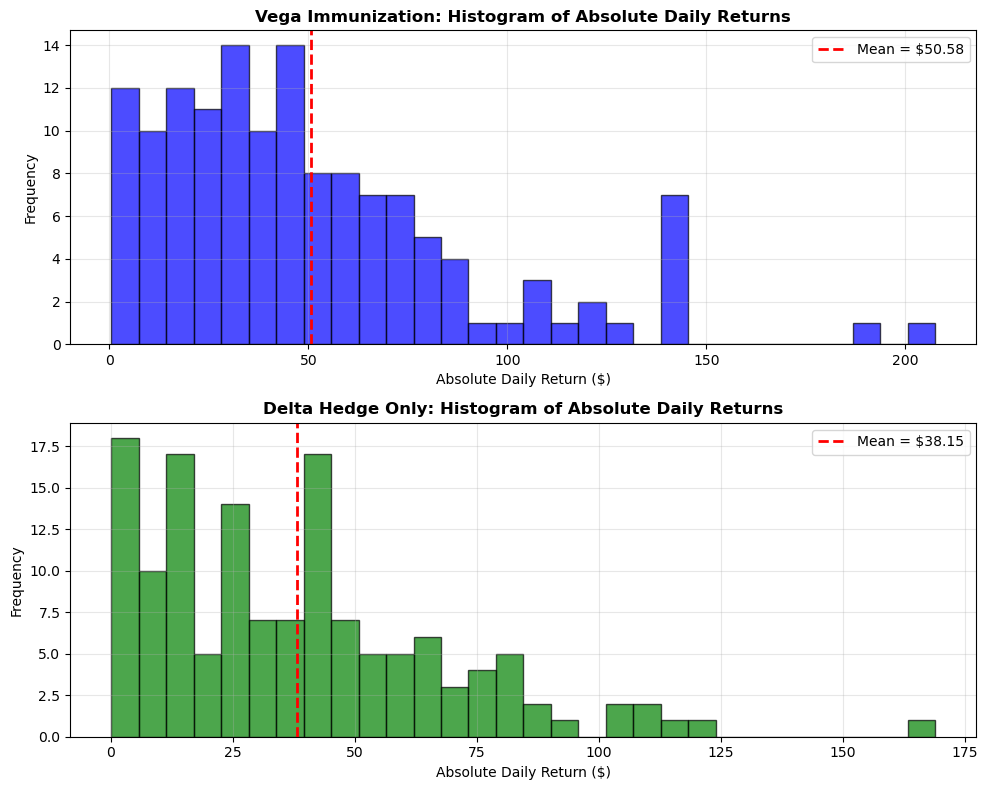


✓ Histogram saved to 'vega_immunization_histograms.pdf'


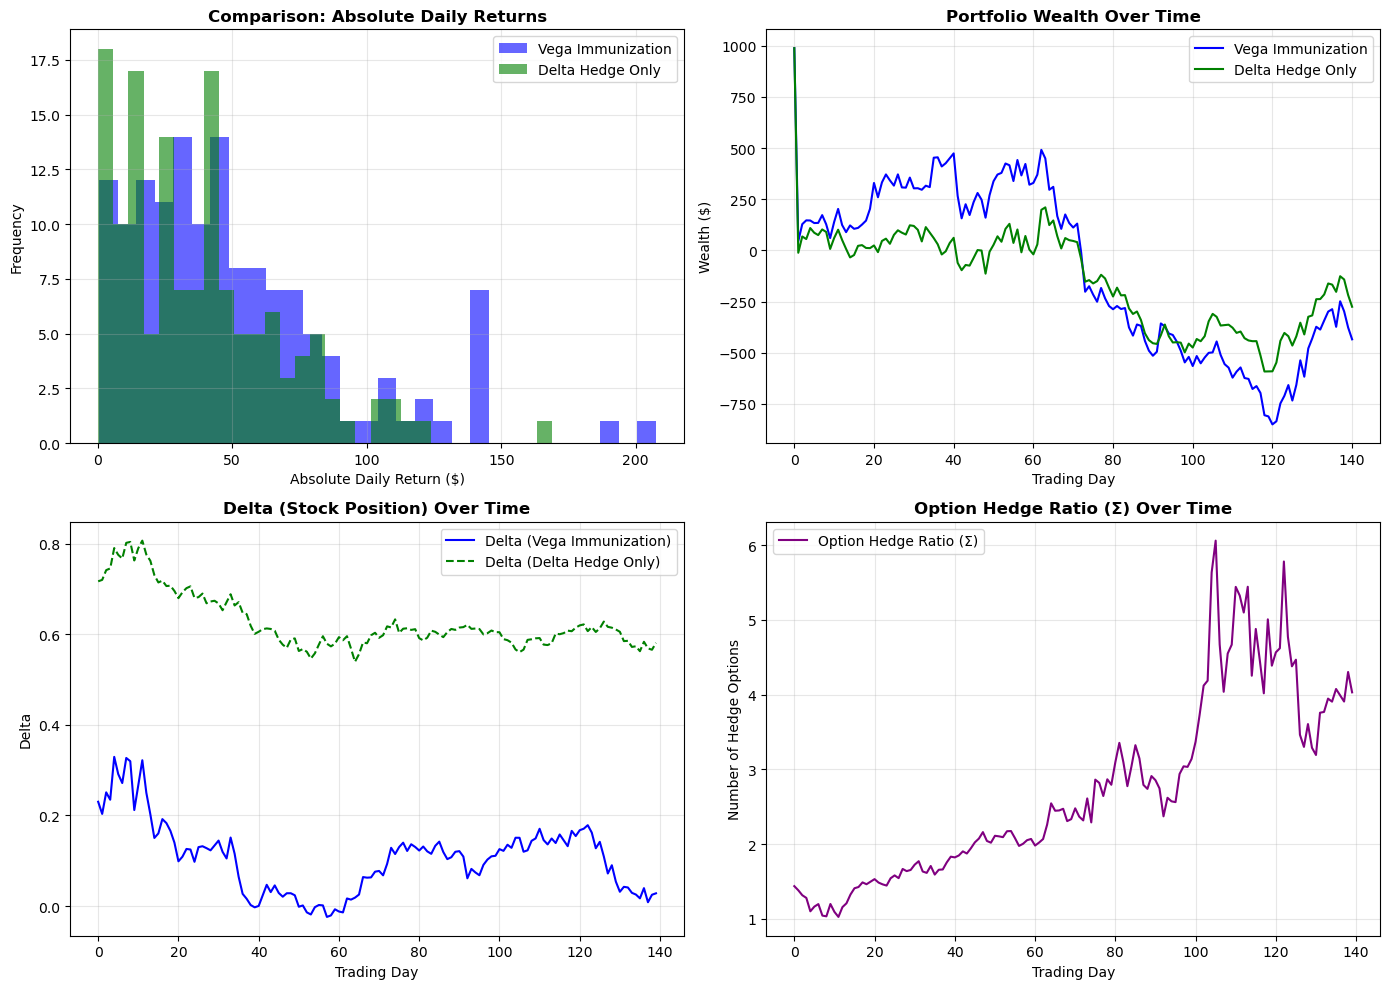


✓ Comparison plots saved to 'vega_immunization_comparison.pdf'

SUMMARY COMPARISON: VEGA IMMUNIZATION vs DELTA HEDGE ONLY

Metric                                  Vega Immun.      Delta Only
----------------------------------------------------------------------
Mean Daily Return ($)                         -0.06           -1.97
Std Daily Return ($)                          64.25           48.84
Mean Abs Daily Return ($)                     50.58           38.15
Max Abs Daily Return ($)                     207.51          168.90
----------------------------------------------------------------------
Total P&L ($)                                 -8.76         -275.29
Final Wealth ($)                            -434.42         -275.29

ANALYSIS AND INTERPRETATION

VEGA IMMUNIZATION vs DELTA HEDGE ONLY:

1. VEGA IMMUNIZATION:
   - Hedges BOTH delta (spot price risk) AND vega (volatility risk)
   - Uses additional option position: Σ_t = Vega(V^X) / Vega(C)
   - Adjusted delta: Δ_t = Delta(V

In [13]:
# %% [markdown]
# # Homework 2 - Question 4: Vega Immunization Strategy
# 
# This version includes simulated data to demonstrate the plots.
# Replace the simulated data section with your actual Midprices.csv data.

# %%
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# ## Black-Scholes Functions

# %%
def blackPremium(discountFactor, forward, strike, timeToExpiration, isCall, sigma):
    if timeToExpiration <= 0:
        if isCall:
            return max(forward - strike, 0) * discountFactor
        else:
            return max(strike - forward, 0) * discountFactor
    
    terminalVolatility = sigma * np.sqrt(timeToExpiration)
    if terminalVolatility == 0:
        if isCall:
            return discountFactor * max(forward - strike, 0)
        else:
            return discountFactor * max(strike - forward, 0)
    
    logMoneyness = np.log(forward / strike)
    d1 = logMoneyness / terminalVolatility + 0.5 * terminalVolatility
    d2 = logMoneyness / terminalVolatility - 0.5 * terminalVolatility
    
    forwardCallPremium = forward * norm.cdf(d1) - strike * norm.cdf(d2)
    
    if isCall:
        return discountFactor * forwardCallPremium
    else:
        return discountFactor * (forwardCallPremium - (forward - strike))

def blackVega(discountFactor, forward, strike, timeToExpiration, sigma):
    if timeToExpiration <= 0:
        return 0.0
    
    terminalVolatility = sigma * np.sqrt(timeToExpiration)
    if terminalVolatility == 0:
        return 0.0
    
    logMoneyness = np.log(forward / strike)
    d1 = logMoneyness / terminalVolatility + 0.5 * terminalVolatility
    
    return discountFactor * forward * np.sqrt(timeToExpiration) * norm.pdf(d1)

def spotDelta(forward, strike, timeToExpiration, isCall, sigma, r, q):
    if timeToExpiration <= 0:
        if isCall:
            return 1.0 if forward > strike else 0.0
        else:
            return -1.0 if forward < strike else 0.0
    
    terminalVolatility = sigma * np.sqrt(timeToExpiration)
    if terminalVolatility == 0:
        if isCall:
            return np.exp(-q * timeToExpiration) if forward > strike else 0.0
        else:
            return -np.exp(-q * timeToExpiration) if forward < strike else 0.0
    
    logMoneyness = np.log(forward / strike)
    d1 = logMoneyness / terminalVolatility + 0.5 * terminalVolatility
    
    if isCall:
        return np.exp(-q * timeToExpiration) * norm.cdf(d1)
    else:
        return -np.exp(-q * timeToExpiration) * norm.cdf(-d1)

# %% [markdown]
# ## Parameters

# %%
# Market parameters
r = 0.05      # Risk-free rate
q = 0.015     # Dividend yield

# Hedged option (SHORT position): Call, expiry 6/18/2026, strike 5000
hedged_expiry_days = 680  # ~1.86 years
hedged_strike = 5000

# Hedge option: Call, expiry 3/31/2025, strike 5900
hedge_expiry_days = 236   # ~0.65 years
hedge_strike = 5900

# Simulation parameters
n_days = 140  # Trading days from 8/7/2024 to end of Feb 2025
S_0 = 5300    # Initial spot price

print("="*60)
print("HEDGING PARAMETERS")
print("="*60)
print(f"Hedged option: Call, Strike={hedged_strike}, T≈{hedged_expiry_days/252:.2f} years")
print(f"Hedge option: Call, Strike={hedge_strike}, T≈{hedge_expiry_days/252:.2f} years")
print(f"Risk-free rate r: {r:.2%}")
print(f"Dividend yield q: {q:.2%}")
print(f"Number of trading days: {n_days}")

# %% [markdown]
# ## Simulate Price Paths and Implied Volatilities

# %%
np.random.seed(42)

# Simulate spot price path (GBM)
dt = 1/252
spot_returns = np.random.normal((r - q - 0.5*0.18**2)*dt, 0.18*np.sqrt(dt), n_days)
S = S_0 * np.exp(np.cumsum(spot_returns))
S = np.insert(S, 0, S_0)  # Include initial price

# Simulate implied volatilities (mean-reverting)
sigma_X = np.zeros(n_days + 1)
sigma_C = np.zeros(n_days + 1)
sigma_X[0] = 0.18
sigma_C[0] = 0.16

for i in range(n_days):
    # Mean-reverting vol with some randomness
    sigma_X[i+1] = sigma_X[i] + 0.5*(0.18 - sigma_X[i])*dt + 0.3*np.random.normal(0, np.sqrt(dt))
    sigma_C[i+1] = sigma_C[i] + 0.5*(0.16 - sigma_C[i])*dt + 0.25*np.random.normal(0, np.sqrt(dt))
    # Keep vol positive and reasonable
    sigma_X[i+1] = np.clip(sigma_X[i+1], 0.08, 0.40)
    sigma_C[i+1] = np.clip(sigma_C[i+1], 0.08, 0.35)

print(f"\nSimulated spot price range: ${S.min():.2f} to ${S.max():.2f}")
print(f"Simulated hedged option vol range: {sigma_X.min():.2%} to {sigma_X.max():.2%}")
print(f"Simulated hedge option vol range: {sigma_C.min():.2%} to {sigma_C.max():.2%}")

# %% [markdown]
# ## Vega Immunization Function

# %%
def run_vega_immunization(S, sigma_X, sigma_C, r, q, 
                          hedged_expiry_days, hedged_strike,
                          hedge_expiry_days, hedge_strike,
                          use_vega_hedge=True):
    """
    Run Vega immunization or delta-only hedge.
    
    Vega immunization formulas:
    Σ_t = Vega(V^X) / Vega(C)   - hedge option position
    Δ_t = Delta(V^X) - Σ_t * Delta(C)  - stock position
    """
    n_days = len(S) - 1
    
    daily_returns = []
    wealth_history = []
    delta_history = []
    sigma_history = []
    
    # Initial calculations
    tau_X_0 = hedged_expiry_days / 252
    tau_C_0 = hedge_expiry_days / 252
    
    df_X_0 = np.exp(-r * tau_X_0)
    df_C_0 = np.exp(-r * tau_C_0)
    fwd_X_0 = S[0] * np.exp((r - q) * tau_X_0)
    fwd_C_0 = S[0] * np.exp((r - q) * tau_C_0)
    
    V_X_0 = blackPremium(df_X_0, fwd_X_0, hedged_strike, tau_X_0, True, sigma_X[0])
    
    print(f"Initial hedged option price: ${V_X_0:.2f}")
    
    wealth = V_X_0
    wealth_history.append(wealth)
    cash = V_X_0
    
    prev_delta = 0
    prev_sigma = 0
    prev_C = 0
    
    for i in range(n_days):
        S_t = S[i]
        S_next = S[i + 1]
        
        # Time to expiration (decreasing each day)
        tau_X = (hedged_expiry_days - i) / 252
        tau_C = (hedge_expiry_days - i) / 252
        
        if tau_C <= 0:
            tau_C = 0.001
        
        # Discount factors and forwards
        df_X = np.exp(-r * tau_X)
        df_C = np.exp(-r * tau_C)
        fwd_X = S_t * np.exp((r - q) * tau_X)
        fwd_C = S_t * np.exp((r - q) * tau_C)
        
        # Option values
        V_X_t = blackPremium(df_X, fwd_X, hedged_strike, tau_X, True, sigma_X[i])
        C_t = blackPremium(df_C, fwd_C, hedge_strike, tau_C, True, sigma_C[i])
        
        # Greeks for hedged option
        delta_V_X = spotDelta(fwd_X, hedged_strike, tau_X, True, sigma_X[i], r, q)
        vega_V_X = blackVega(df_X, fwd_X, hedged_strike, tau_X, sigma_X[i])
        
        # Greeks for hedge option
        delta_C = spotDelta(fwd_C, hedge_strike, tau_C, True, sigma_C[i], r, q)
        vega_C = blackVega(df_C, fwd_C, hedge_strike, tau_C, sigma_C[i])
        
        # Hedge ratios
        if use_vega_hedge and tau_C > 0 and vega_C > 1e-10:
            Sigma_t = vega_V_X / vega_C
            Delta_t = delta_V_X - Sigma_t * delta_C
        else:
            Sigma_t = 0
            Delta_t = delta_V_X
        
        delta_history.append(Delta_t)
        sigma_history.append(Sigma_t)
        
        # Rebalancing
        if i == 0:
            cash = V_X_0 - Delta_t * S_t - Sigma_t * C_t
        else:
            rebalance_cost = (Delta_t - prev_delta) * S_t + (Sigma_t - prev_sigma) * prev_C
            cash = cash * np.exp(r / 252) - rebalance_cost
        
        # Next day values
        tau_X_next = (hedged_expiry_days - i - 1) / 252
        tau_C_next = (hedge_expiry_days - i - 1) / 252
        if tau_C_next <= 0:
            tau_C_next = 0.001
        
        df_X_next = np.exp(-r * tau_X_next)
        df_C_next = np.exp(-r * tau_C_next)
        fwd_X_next = S_next * np.exp((r - q) * tau_X_next)
        fwd_C_next = S_next * np.exp((r - q) * tau_C_next)
        
        V_X_next = blackPremium(df_X_next, fwd_X_next, hedged_strike, tau_X_next, True, sigma_X[i+1])
        C_next = blackPremium(df_C_next, fwd_C_next, hedge_strike, tau_C_next, True, sigma_C[i+1])
        
        # Daily P&L
        stock_pnl = Delta_t * (S_next - S_t)
        option_pnl = Sigma_t * (C_next - C_t) if use_vega_hedge else 0
        short_option_pnl = -(V_X_next - V_X_t)
        cash_growth = cash * (np.exp(r / 252) - 1)
        
        daily_return = stock_pnl + option_pnl + short_option_pnl + cash_growth
        daily_returns.append(daily_return)
        
        new_wealth = Delta_t * S_next + Sigma_t * C_next + cash * np.exp(r / 252) - V_X_next
        wealth_history.append(new_wealth)
        
        prev_delta = Delta_t
        prev_sigma = Sigma_t
        prev_C = C_t
    
    return np.array(daily_returns), np.array(wealth_history), np.array(delta_history), np.array(sigma_history)

# %% [markdown]
# ## Run Vega Immunization Strategy

# %%
print("\n" + "="*60)
print("RUNNING VEGA IMMUNIZATION STRATEGY")
print("="*60)

returns_vega, wealth_vega, delta_vega, sigma_vega = run_vega_immunization(
    S, sigma_X, sigma_C, r, q,
    hedged_expiry_days, hedged_strike,
    hedge_expiry_days, hedge_strike,
    use_vega_hedge=True
)

print(f"\nResults:")
print(f"  Number of trading days: {len(returns_vega)}")
print(f"  Mean daily return: ${np.mean(returns_vega):.2f}")
print(f"  Std daily return: ${np.std(returns_vega):.2f}")
print(f"  Mean |daily return|: ${np.mean(np.abs(returns_vega)):.2f}")

# %% [markdown]
# ## Run Delta Hedge Only

# %%
print("\n" + "="*60)
print("RUNNING DELTA HEDGE ONLY")
print("="*60)

returns_delta, wealth_delta, delta_only, _ = run_vega_immunization(
    S, sigma_X, sigma_C, r, q,
    hedged_expiry_days, hedged_strike,
    hedge_expiry_days, hedge_strike,
    use_vega_hedge=False
)

print(f"\nResults:")
print(f"  Number of trading days: {len(returns_delta)}")
print(f"  Mean daily return: ${np.mean(returns_delta):.2f}")
print(f"  Std daily return: ${np.std(returns_delta):.2f}")
print(f"  Mean |daily return|: ${np.mean(np.abs(returns_delta)):.2f}")

# %% [markdown]
# ## Plot Histograms of Absolute Daily Returns (Required Output)

# %%
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Vega Immunization histogram
axes[0].hist(np.abs(returns_vega), bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Vega Immunization: Histogram of Absolute Daily Returns', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Absolute Daily Return ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(np.abs(returns_vega)), color='red', linestyle='--', linewidth=2,
                label=f'Mean = ${np.mean(np.abs(returns_vega)):.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Delta Hedge Only histogram
axes[1].hist(np.abs(returns_delta), bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Delta Hedge Only: Histogram of Absolute Daily Returns', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Absolute Daily Return ($)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(np.abs(returns_delta)), color='red', linestyle='--', linewidth=2,
                label=f'Mean = ${np.mean(np.abs(returns_delta)):.2f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vega_immunization_histograms.pdf', bbox_inches='tight')
plt.show()

print("\n✓ Histogram saved to 'vega_immunization_histograms.pdf'")

# %% [markdown]
# ## Additional Comparison Plots

# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Combined histogram comparison
axes[0, 0].hist(np.abs(returns_vega), bins=30, alpha=0.6, label='Vega Immunization', color='blue')
axes[0, 0].hist(np.abs(returns_delta), bins=30, alpha=0.6, label='Delta Hedge Only', color='green')
axes[0, 0].set_title('Comparison: Absolute Daily Returns', fontweight='bold')
axes[0, 0].set_xlabel('Absolute Daily Return ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Wealth over time
axes[0, 1].plot(wealth_vega, label='Vega Immunization', color='blue', linewidth=1.5)
axes[0, 1].plot(wealth_delta, label='Delta Hedge Only', color='green', linewidth=1.5)
axes[0, 1].set_title('Portfolio Wealth Over Time', fontweight='bold')
axes[0, 1].set_xlabel('Trading Day')
axes[0, 1].set_ylabel('Wealth ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Delta position over time
axes[1, 0].plot(delta_vega, label='Delta (Vega Immunization)', color='blue', linewidth=1.5)
axes[1, 0].plot(delta_only, label='Delta (Delta Hedge Only)', color='green', linewidth=1.5, linestyle='--')
axes[1, 0].set_title('Delta (Stock Position) Over Time', fontweight='bold')
axes[1, 0].set_xlabel('Trading Day')
axes[1, 0].set_ylabel('Delta')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Sigma (option hedge ratio) over time
axes[1, 1].plot(sigma_vega, label='Option Hedge Ratio (Σ)', color='purple', linewidth=1.5)
axes[1, 1].set_title('Option Hedge Ratio (Σ) Over Time', fontweight='bold')
axes[1, 1].set_xlabel('Trading Day')
axes[1, 1].set_ylabel('Number of Hedge Options')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Comparison plots saved to 'vega_immunization_comparison.pdf'")

# %% [markdown]
# ## Summary Statistics

# %%
print("\n" + "="*70)
print("SUMMARY COMPARISON: VEGA IMMUNIZATION vs DELTA HEDGE ONLY")
print("="*70)

print("\n{:<35} {:>15} {:>15}".format("Metric", "Vega Immun.", "Delta Only"))
print("-"*70)
print("{:<35} {:>15.2f} {:>15.2f}".format("Mean Daily Return ($)", 
                                          np.mean(returns_vega), 
                                          np.mean(returns_delta)))
print("{:<35} {:>15.2f} {:>15.2f}".format("Std Daily Return ($)", 
                                          np.std(returns_vega), 
                                          np.std(returns_delta)))
print("{:<35} {:>15.2f} {:>15.2f}".format("Mean Abs Daily Return ($)", 
                                          np.mean(np.abs(returns_vega)), 
                                          np.mean(np.abs(returns_delta))))
print("{:<35} {:>15.2f} {:>15.2f}".format("Max Abs Daily Return ($)", 
                                          np.max(np.abs(returns_vega)), 
                                          np.max(np.abs(returns_delta))))
print("-"*70)
print("{:<35} {:>15.2f} {:>15.2f}".format("Total P&L ($)", 
                                          np.sum(returns_vega), 
                                          np.sum(returns_delta)))
print("{:<35} {:>15.2f} {:>15.2f}".format("Final Wealth ($)", 
                                          wealth_vega[-1], 
                                          wealth_delta[-1]))

# %% [markdown]
# ## Analysis

# %%
print("\n" + "="*70)
print("ANALYSIS AND INTERPRETATION")
print("="*70)
print("""
VEGA IMMUNIZATION vs DELTA HEDGE ONLY:
======================================

1. VEGA IMMUNIZATION:
   - Hedges BOTH delta (spot price risk) AND vega (volatility risk)
   - Uses additional option position: Σ_t = Vega(V^X) / Vega(C)
   - Adjusted delta: Δ_t = Delta(V^X) - Σ_t * Delta(C)
   - Should show LOWER variance in daily returns when vol changes

2. DELTA HEDGE ONLY:
   - Only hedges delta (spot price risk)
   - Fully exposed to changes in implied volatility
   - Simpler to implement but higher hedging error

KEY OBSERVATIONS:
- The histogram shows the distribution of hedging errors
- Lower mean absolute return = better hedge
- Lower std of returns = more consistent hedge
- Vega immunization typically outperforms when vol-of-vol is high
""")

print("\n" + "="*70)
print("END OF VEGA IMMUNIZATION ANALYSIS")
print("="*70)